# Teoria da Decisão - ELE088

*Prof. Lucas S. Batista*  
*Departamento de Engenharia Elétrica*  
*Universidade Federal de Minas Gerais* 

# Estudo de Caso

## Problema da Mochila Binário:

- Considere $n$ projetos e um capital de investimento $b$. O projeto $j$ tem um custo $a_j$ e um retorno esperado $p_j$. Formule um problema que permita selecionar o portfólio de projetos que maximiza o retorno sem exceder os recursos disponíveis. 

## Modelagem do problema

Assumindo que $x_{j}$ represente as variáveis de otimização do problema, pode-se definir que se $x_{j} = 1$, então o projeto $j$ é selecionado; caso contrário, i.e., se $x_{j} = 0$, então o $j$-ésimo projeto não é escolhido.

Com o intúito de maximizar o retorno total do portifólio de projetos, pode-se escrever a seguinte função objetivo:

$$ \max_x \sum_{j=1}^{n} p_{j} x_{j} $$

Adicionalmente, este problema apresenta o seguinte conjunto de restrições:

\begin{align} 
\sum_{j=1}^{n} a_j x_j \leq b, \hspace{2cm} (R1) \\
x_{j} \in \{0, 1\}, \forall j \in \{1, \ldots, n\} \hspace{2cm} (R2)
\end{align}

em que **R1** assegura que o portifólio de projetos escolhidos não ultrapassará o limite de capital disponível; e **R2** define o domínio das variáveis de decisão $x_{j}$.

## Otimização de uma instância arbitrária do problema via RVNS

A seguir são apresentados os trechos de código da implementação do RVNS para o estudo de caso apresentado.

In [1]:
'''
Importa os módulos usados
'''
import numpy as np
import matplotlib.pyplot as plt
import copy

'''
Define um tipo de dado similar ao Pascal "record" or C "struct"
'''
class Struct:
    pass

Os dados da instância teste são definidos a seguir. Note que considera-se um número de projetos *default* $n = 50$. Além disso, assume-se um vetor de custos $a$ em que o custo de investimento em um projeto $j$ é dado na posição $a_j$; de forma semelhante, tem-se um vetor de retornos $p$ em que o retorno financeiro de um projeto $j$ é dado na posição $p_j$. O capital de investimento disponível é informado em $b$.

In [2]:
'''
Define os dados de uma instância arbitrária do problema
'''
def probdef(n=50):
    
    # n: número de projetos considerados
        
    '''
    Vetor de custos:    a = [a1 a2 a3 ... an]
    Vetor de retornos   p = [p1 p2 p3 ... pn]
    Capital disponível: b
    
    '''
    
    np.random.seed(13) 
    a = np.random.randint(10,100,size=n)    # considera custos inteiros aleatórios no conjunto {10, 11, ..., 99}
    p = 10*np.random.randint(10,100,size=n) # considera retornos inteiros aleatórios no conjunto 10*{10, 11, ..., 99}
    b = 0.6*a.sum(axis=0) # capital disponível igual a 60% do montante necessário para investir em todos os projetos
    np.random.seed()
    
    probdata = Struct()
    probdata.a = a
    probdata.p = p
    probdata.b = b
    probdata.n = n
    
    return probdata

Uma solução candidata $x = (x_1, x_2, ..., x_n)$ para o problema foi modelada computacionalmente como um vetor binário, em que $x_j = 1$ indica aporte de investimento no $j$-ésimo projeto; caso contrário, $x_j = 0$.

In [3]:
'''
Implementa uma solução inicial para o problema
'''
def sol_inicial(probdata,apply_constructive_heuristic):
    
    '''  
    Modelou-se uma solução x como um vetor binário
    
    x = [x1 x2 ... xn]
    '''
        
    if apply_constructive_heuristic == False:
        # Constrói solução inicial aleatoriamente
        x = Struct()    
        x.solution = np.random.randint(0,2,size=probdata.n)   
        
    else:
        # Constrói solução inicial usando uma heurística construtiva
        x = Struct()
        x.solution = np.zeros(shape=probdata.n,dtype=int)
        sorted_projects = np.argsort(probdata.p - probdata.a) # projetos ordenados considerando a diferença 'pj - aj' 

        custo_acumulado = 0.0                   # inclue os melhores projetos até atingir o capital limite
        for proj in sorted_projects[::-1]:
            custo_acumulado += probdata.a[proj]
            if custo_acumulado <= probdata.b:
                x.solution[proj] = 1
            else:
                break
    
    return x

A função objetivo é implementada conforme a definição apresentada anteriormente. De forma geral, dada uma solução $x$, que indica os projetos escolhidos para investimento, esta função computa o somatório dos retornos relacionados.

In [4]:

'''
Implementa a função objetivo do problema
'''
def fobj(x, probdata):
    
    '''      
    x = [x1 x2 ... xn]
    '''
    
    sol     = np.transpose(np.array(x.solution))          # vetor solução transposto
    retorno = np.array(probdata.p)                        # vetor com os retornos
    custo   = np.array(probdata.a)                        # vetor com os custos
    
    g = np.dot(custo, sol) - probdata.b                   # valor da restrição R2 para a solução x
    x.fitness = - np.dot(retorno, sol)                    # negativo do retorno total da solução candidata x
    x.penalidade = 100*np.sum(np.where(g <= 0, 0, g)**2)  # penalidade aplicada sobre a solução x
    x.fitness_penalizado = x.fitness + x.penalidade       # negativo do retorno total penalizado da solução x
    
    return x

A função *neighborhoodChange* atualiza a solução corrente e também a estrutura de vizinhança. De forma geral, se a nova solução gerada $(y, fy)$ apresentar um retorno financeiro maior do que a solução incumbente $(x, fx)$, então a solução incumbente é atualizada e mantém-se/retoma-se a primeira estrutura, i.e., faz-se $k = 1$. Caso contrário, apenas segue-se para a próxima estrutura de vizinhança.

In [5]:
'''
Implementa a função neighborhoodChange
'''
def neighborhoodChange(x, y, k):
    
    if y.fitness_penalizado < x.fitness_penalizado:
        x = copy.deepcopy(y)
        k  = 1
    else:
        k += 1
        
    return x, k

Para o estudo de caso em questão foram propostas três estruturas de vizinhanças:

1. A 1a estrutura de vizinhança aplica o operador *not* sobre $01$ posição escolhida arbitrariamente em $x$.
2. A 2a estrutura de vizinhança aplica o operador *not* sobre $02$ posições escolhidas arbitrariamente em $x$.
3. A 3a estrutura de vizinhança aplica o operador *not* sobre $03$ posições escolhidas arbitrariamente em $x$.

In [6]:
'''
Implementa a função shake
'''
def shake(x,k,probdata):
    
    y = copy.deepcopy(x)
    r = np.random.permutation(probdata.n)       
    
    if k == 1:             # apply not operator in one random position
        y.solution[r[0]] = not(y.solution[r[0]])
        
    elif k == 2:           # apply not operator in two random positions        
        y.solution[r[0]] = not(y.solution[r[0]])
        y.solution[r[1]] = not(y.solution[r[1]])
        
    elif k == 3:           # apply not operator in three random positions
        y.solution[r[0]] = not(y.solution[r[0]])
        y.solution[r[1]] = not(y.solution[r[1]])
        y.solution[r[2]] = not(y.solution[r[2]])        
    
    return y

### Estrutura principal do método RVNS


--- SOLUÇÃO INICIAL CONSTRUÍDA ---

Identificação dos projetos selecionados:

x = [0 1 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 1 0 1 0 1 0 1 1 1 0 0 0 1 1 0 1 0 0 1 1
 0 1 1 1 1 1 1 0 1 1 0 0 1]

fitness(x) = -13870.00

fitness(x) penalizado = -13870.00

penalidade(x) = 0.00


--- MELHOR SOLUÇÃO ENCONTRADA ---

Identificação dos projetos selecionados:

x = [0 1 1 1 1 0 0 1 1 1 1 0 0 1 0 1 1 1 1 1 0 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 0
 0 1 1 1 0 1 1 1 0 0 0 1 1]

fitness(x) = -20790.00

fitness(x) penalizado = -20790.00

penalidade(x) = 0.00



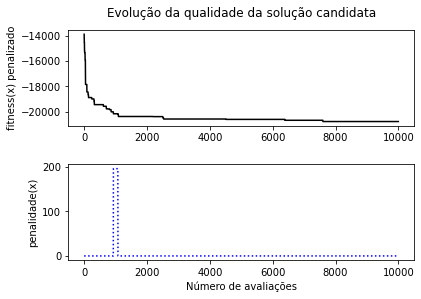

In [7]:
'''
Implementa uma metaheurística RVNS
'''

# Contador do número de soluções candidatas avaliadas
num_sol_avaliadas = 0

# Máximo número de soluções candidatas avaliadas
max_num_sol_avaliadas = 10000

# Número de estruturas de vizinhanças definidas
kmax = 3

# Faz a leitura dos dados da instância do problema
probdata = probdef(n=50)

# Gera solução inicial
x = sol_inicial(probdata,apply_constructive_heuristic=False)

# Avalia solução inicial
x = fobj(x,probdata)
num_sol_avaliadas += 1

# Armazena dados para plot
historico = Struct()
historico.fit = []
historico.sol = []
historico.pen = []
historico.fit_pen = []
historico.fit.append(x.fitness)
historico.sol.append(x.solution)
historico.pen.append(x.penalidade)
historico.fit_pen.append(x.fitness_penalizado)


# Ciclo iterativo do método
while num_sol_avaliadas < max_num_sol_avaliadas:
    
    k = 1
    while k <= kmax:
        
        # Gera uma solução candidata na k-ésima vizinhança de x          
        y = shake(x,k,probdata)
        y = fobj(y,probdata)
        num_sol_avaliadas += 1
        
        # Atualiza solução corrente e estrutura de vizinhança (se necessário)
        x, k = neighborhoodChange(x, y, k)
        
        # Armazena dados para plot
        historico.fit.append(x.fitness)
        historico.sol.append(x.solution)
        historico.pen.append(x.penalidade)
        historico.fit_pen.append(x.fitness_penalizado)


print('\n--- SOLUÇÃO INICIAL CONSTRUÍDA ---\n')
print('Identificação dos projetos selecionados:\n')
print('x = {}\n'.format(historico.sol[0]))
print('fitness(x) = {:.2f}\n'.format(historico.fit[0]))
print('fitness(x) penalizado = {:.2f}\n'.format(historico.fit_pen[0]))
print('penalidade(x) = {:.2f}\n'.format(historico.pen[0]))

print('\n--- MELHOR SOLUÇÃO ENCONTRADA ---\n')
print('Identificação dos projetos selecionados:\n')
print('x = {}\n'.format(x.solution))
print('fitness(x) = {:.2f}\n'.format(x.fitness))
print('fitness(x) penalizado = {:.2f}\n'.format(x.fitness_penalizado))
print('penalidade(x) = {:.2f}\n'.format(x.penalidade))

fig, (ax1, ax2) = plt.subplots(2, 1)
s = len(historico.fit_pen)
ax1.plot(np.linspace(0,s-1,s),historico.fit_pen,'k-')
ax2.plot(np.linspace(0,s-1,s),historico.pen,'b:')
fig.suptitle('Evolução da qualidade da solução candidata')
ax1.set_ylabel('fitness(x) penalizado')
ax2.set_ylabel('penalidade(x)')
ax2.set_xlabel('Número de avaliações')
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
plt.show()